## Extract true signal from background noise using clustering algorithms

In this notebook we show how signal classification is done in qibocal for flux_dependence protocols.
I this protocols we deal with a 2D signal, which corresponds to different spectroscopies (either qubit or resonator) for different DC flux biases.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import skimage.filters as filters
import skimage.morphology as morphology
from scipy import ndimage
from scipy.signal import find_peaks
from skimage import exposure
from sklearn.cluster import HDBSCAN

here we load a dataset from an actual qubit_flux qibocal experiment performed on QPU qw21q-b

In [73]:
datafile = "/home/lorenzo/Desktop/improve_mask_branch_error_in_ResonatorFlux_2/data/resonator_flux-3/data.npz"
# datafile = '/home/lorenzo/Desktop/improve_mask_branch_error_in_QubitFlux_3/data/qubit_flux-2/data.npz'
data = np.load(datafile)
keys_list = list(data.keys())
a = data[keys_list[0]]
f = a["freq"]
b = a["bias"]
sig = a["signal"]
s = a["signal"].reshape(np.unique(b).size, np.unique(f).size)

find_min_peak = True if "ResonatorFlux" in datafile else False

we expect the signal to be something like:

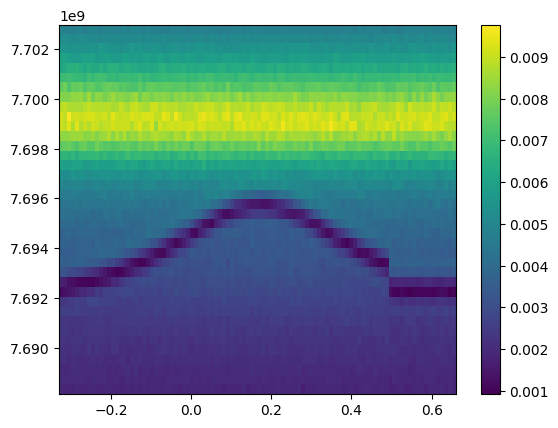

In [74]:
plt.imshow(
    s.T, origin="lower", aspect="auto", extent=[b.min(), b.max(), f.min(), f.max()]
)
plt.colorbar()

where it is clear the signal we want to extract (parabola-shape curve);

for some pathological cases (such as this one), where the SNR is not big enough, find_peaks fails to identify the peaks and hence the signal.

So we need to implement a more sophisticated procedure, such as the one described below. 

The full routine is implemented in qibocal package and can be imported in the following way:

In [99]:
def zca_whiten(X):
    """
    Applies ZCA whitening to the data (X)
    http://xcorr.net/2011/05/27/whiten-a-mfilters.gaussianatrix-matlab-code/

    X: numpy 2d array
        input data, rows are data points, columns are features

    Returns: ZCA whitened 2d array
    """
    assert X.ndim == 2
    EPS = 10e-5

    #   covariance matrix
    cov = np.dot(X.T, X)
    #   d = (lambda1, lambda2, ..., lambdaN)
    d, E = np.linalg.eigh(cov)
    #   D = diag(d) ^ (-1/2)
    D = np.diag(1.0 / np.sqrt(d + EPS))
    #   W_zca = E * D * E.T
    W = np.dot(np.dot(E, D), E.T)

    X_white = np.dot(X, W)

    return X_white


def custom_filter_mask(matrix_z: np.ndarray):
    """Applying a mask compsosed by first a ZCA transformation and then a gaussian filter with variance 1."""

    zca_z = zca_whiten(matrix_z)
    # adding zca filter for filtering out background noise gradient
    zca_gauss_z = ndimage.gaussian_filter(zca_z, 1)
    # adding gaussia fliter with unitary variance for blurring the signal and reducing noise

    return zca_gauss_z


def clustering(data: tuple, min_points_per_cluster: int) -> list[bool]:
    """Divides the processed signal into clusters for separating signal from noise.

    In this function Hierarchical Density-Based Spatial Clustering of Applications with Noise (HDBSCAN) algorithm is used;
    HDBSCAN good for successfully capture clusters with different densities.

    `data_dict` is a 3D tuple of the data to cluster, while `min_points_per_cluster` is the minimum size of points for a cluster to be considered relevant signal.
    It allows a `min_cluster_size=2` in order to decrease as much as possible misclassification of few points.
    The function returns a boolean list corresponding to the indices of the relevant signal.
    """

    hdb = HDBSCAN(copy=True, min_cluster_size=2, cluster_selection_epsilon=5.0)

    peaks_vals = data[2]
    X = np.stack(data).T
    hdb.fit(X)
    hdb.labels_.shape == (X.shape[0],)
    labels = hdb.labels_

    clusters = np.unique(labels)
    valid_clusters = [
        c for c in clusters if np.sum(labels == c) >= min_points_per_cluster
    ]
    # since we allowed for clustering even a group of 2 points, we filter the allowed eligible clusters
    # to be at least composed by a minimum number of points given by min_points_per_cluster parameter

    medians = [np.median(peaks_vals[labels == c]) for c in valid_clusters]
    if len(medians) == 0:
        return [False] * len(labels)

    signal = valid_clusters[np.argmax(medians)]
    # in general the true signal has the highest magnitude across the whoole dataset, so we distinguish
    # if from background noise by selecting the cluster with the highest median of the signal

    return labels == signal


def scaling(sig: np.ndarray) -> np.ndarray:
    sig_min = np.min(sig)
    return (sig - sig_min) / (np.max(sig) - sig_min)


def horizontal_diagonal(xs: np.ndarray, ys: np.ndarray) -> float:
    sizes = np.empty(2)
    for i, values in enumerate([xs, ys]):
        sizes[i] = np.max(values) - np.min(values)
    return np.sqrt((sizes**2).sum())


def build_clustering_data(peaks_dict: dict, z: np.ndarray):
    peaks_x = peaks_dict["x"]["idx"]
    peaks_y = peaks_dict["y"]["idx"]
    peaks_sf = z[peaks_y, peaks_x]

    diag = horizontal_diagonal(peaks_x, peaks_y)
    diag = np.sqrt(2)
    return (peaks_x, peaks_y, scaling(peaks_sf) * diag)


def scaling_slice(sig: np.ndarray) -> np.ndarray:
    sig_min = np.min(sig, axis=1)
    return ((sig.T - sig_min) / (np.max(sig, axis=1) - sig_min)).T


def peaks_finder(x, y, z, find_min) -> dict:
    # filter data using find_peaks
    peaks = {"x": {"idx": [], "val": []}, "y": {"idx": [], "val": []}}
    for y_idx, y_val in enumerate(y):
        signal_fixed_y = z[y_idx]
        peak, info = find_peaks(
            -signal_fixed_y if find_min else signal_fixed_y, prominence=0.2
        )
        if len(peak) > 0:
            idx = np.argmax(info["prominences"])
            # if multiple peaks per bias are found, select the one with the highest prominence
            x_idx = peak[idx]
            peaks["x"]["idx"].append(x_idx)
            peaks["x"]["val"].append(x[x_idx])
            peaks["y"]["idx"].append(y_idx)
            peaks["y"]["val"].append(y_val)

    peaks_dict = {
        feat: {kind: np.array(vals) for kind, vals in smth.items()}
        for feat, smth in peaks.items()
    }

    return peaks_dict

In [100]:
def extract_feature(
    x: np.ndarray,
    y: np.ndarray,
    z: np.ndarray,
    find_min: bool,
    clustering_flag: bool,
    min_points: int = 5,
) -> tuple[np.ndarray, np.ndarray]:
    """Extract features of the signal by filtering out background noise.

    It first applies a custom filter mask (see `custom_filter_mask`)
    and then finds the biggest peak for each DC bias value;
    the masked signal is then clustered (see `clustering`) in order to classify the relevant signal for the experiment.
    If `find_min` is set to `True` it finds minimum peaks of the input signal;
    `min_points` is the minimum number of points for a cluster to be considered relevant signal.
    Position of the relevant signal is returned.
    """

    x_ = np.unique(x)
    y_ = np.unique(y)
    # background removed over y axis
    z_ = z.reshape(len(y_), len(x_))

    # masking
    z_masked = custom_filter_mask(z_)

    # renormalizing
    # z_masked_norm = scaling_signal(z_masked)
    z_masked_norm = scaling_slice(z_masked)

    # filter data using find_peaks
    peaks_dict = peaks_finder(x_, y_, z_masked_norm, find_min)

    if clustering_flag:
        # normalizing peaks for clustering
        clustering_tuple = build_clustering_data(peaks_dict, z_masked)

        # clustering
        signal_classification = clustering(clustering_tuple, min_points)
        new_peaks_dict = {
            feat: {
                kind: np.array(vals)[signal_classification]
                for kind, vals in smth.items()
            }
            for feat, smth in peaks_dict.items()
        }
    else:
        new_peaks_dict = peaks_dict

    return new_peaks_dict, z_masked


# def extract_feature_old(
#     x: np.ndarray, y: np.ndarray, z: np.ndarray, find_min: bool) -> tuple[np.ndarray, np.ndarray]:
#     """Extract features of the signal by filtering out background noise.

#     It first applies a custom filter mask (see `custom_filter_mask`)
#     and then finds the biggest peak for each DC bias value;
#     the masked signal is then clustered (see `clustering`) in order to classify the relevant signal for the experiment.
#     If `find_min` is set to `True` it finds minimum peaks of the input signal;
#     `min_points` is the minimum number of points for a cluster to be considered relevant signal.
#     Position of the relevant signal is returned.
#     """

#     x_ = np.unique(x)
#     y_ = np.unique(y)
#     # background removed over y axis
#     z_masked = z.reshape(len(y_), len(x_))
#     z_min = np.min(z_masked, axis=1)
#     z_masked_norm = ((z_masked.T - z_min) / (np.max(z_masked, axis=1) - z_min)).T

#     # filter data using find_peaks
#     peaks = {"x": {"idx": [], "val": []}, "y": {"idx": [], "val": []}}
#     for y_idx, y_val in enumerate(y_):
#         signal_fixed_y = z_masked_norm[y_idx]
#         peak, info = find_peaks(
#             -signal_fixed_y if find_min else signal_fixed_y, prominence=0.2
#         )
#         if len(peak) > 0:
#             idx = np.argmax(info["prominences"])
#             # if multiple peaks per bias are found, select the one with the highest prominence
#             x_idx = peak[idx]
#             peaks["x"]["idx"].append(x_idx)
#             peaks["x"]["val"].append(x_[x_idx])
#             peaks["y"]["idx"].append(y_idx)
#             peaks["y"]["val"].append(y_val)

#     peaks_dict = {
#         feat: {kind: np.array(vals) for kind, vals in smth.items()}
#         for feat, smth in peaks.items()
#     }

#     return peaks_dict, z_masked

In [101]:
def extract_and_plot(
    _signal,
    _freq,
    _bias,
    find_min_flag: bool = False,
    clustering_flag: bool = False,
    min_cluster_points: int = 5,
):
    _peaks, _sig = extract_feature(
        _freq, _bias, _signal, find_min_flag, clustering_flag, min_cluster_points
    )

    _freq_points = _peaks["x"]["val"]
    _bias_points = _peaks["y"]["val"]

    plt.imshow(
        _sig.T,
        origin="lower",
        aspect="auto",
        extent=[_bias.min(), _bias.max(), _freq.min(), _freq.max()],
    )
    plt.colorbar()

    plt.scatter(_bias_points, _freq_points, c="r", lw=1, ec="k", s=20)

    return _peaks, _sig

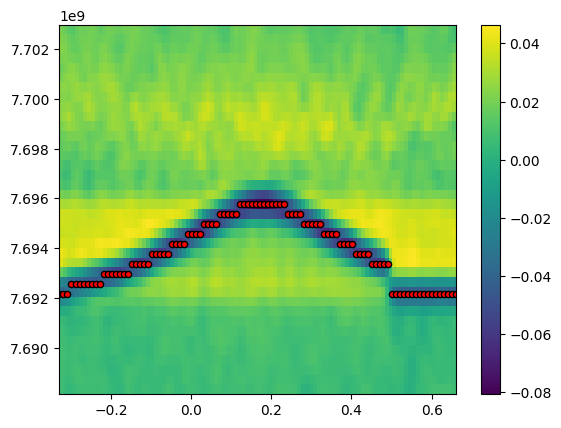

In [102]:
results, sg = extract_and_plot(
    s, f, b, find_min_flag=find_min_peak, clustering_flag=False, min_cluster_points=5
)

In [103]:
np.stack((results["x"]["idx"], results["y"]["idx"])).T

array([[10,  0],
       [10,  1],
       [10,  2],
       [11,  3],
       [11,  4],
       [11,  5],
       [11,  6],
       [11,  7],
       [11,  8],
       [11,  9],
       [11, 10],
       [12, 11],
       [12, 12],
       [12, 13],
       [12, 14],
       [12, 15],
       [12, 16],
       [12, 17],
       [13, 18],
       [13, 19],
       [13, 20],
       [13, 21],
       [13, 22],
       [14, 23],
       [14, 24],
       [14, 25],
       [14, 26],
       [14, 27],
       [15, 28],
       [15, 29],
       [15, 30],
       [15, 31],
       [16, 32],
       [16, 33],
       [16, 34],
       [16, 35],
       [17, 36],
       [17, 37],
       [17, 38],
       [17, 39],
       [18, 40],
       [18, 41],
       [18, 42],
       [18, 43],
       [18, 44],
       [19, 45],
       [19, 46],
       [19, 47],
       [19, 48],
       [19, 49],
       [19, 50],
       [19, 51],
       [19, 52],
       [19, 53],
       [19, 54],
       [19, 55],
       [19, 56],
       [18, 57],
       [18, 58

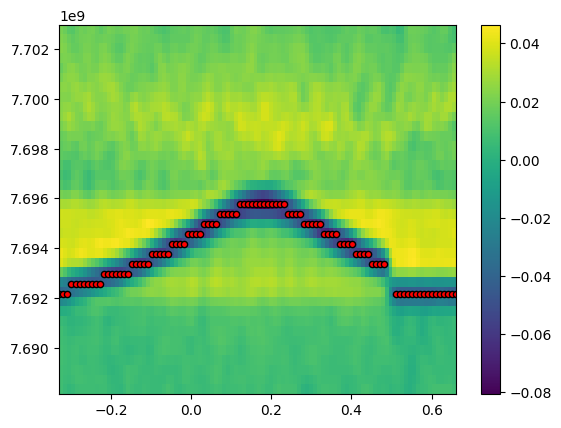

In [104]:
extract_and_plot(
    s, f, b, find_min_flag=find_min_peak, clustering_flag=True, min_cluster_points=5
);

In [128]:
# zca = zca_whiten(s)
# zca_sg = ndimage.gaussian_filter(zca, 1)
# results = extract_and_plot(zca_sg, f, b, find_min_flag=True, min_cluster_points=5, old_flag=True);

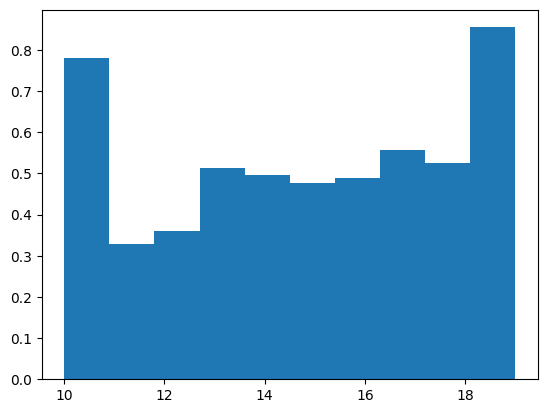

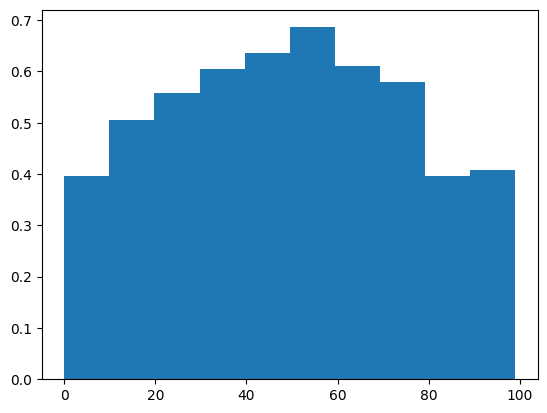

In [129]:
peaks_vals = results["x"]["val"]
# unique_values, counts = np.unique(arr, return_counts=True)
peaks_x = results["x"]["idx"]
peaks_y = results["y"]["idx"]
peaks_sf = (-1) ** find_min_peak * sg[peaks_y, peaks_x]
plt.figure(0)
plt.hist(peaks_x, weights=peaks_sf)
plt.figure(1)
plt.hist(peaks_y, weights=peaks_sf);

<IPython.core.display.Javascript object>


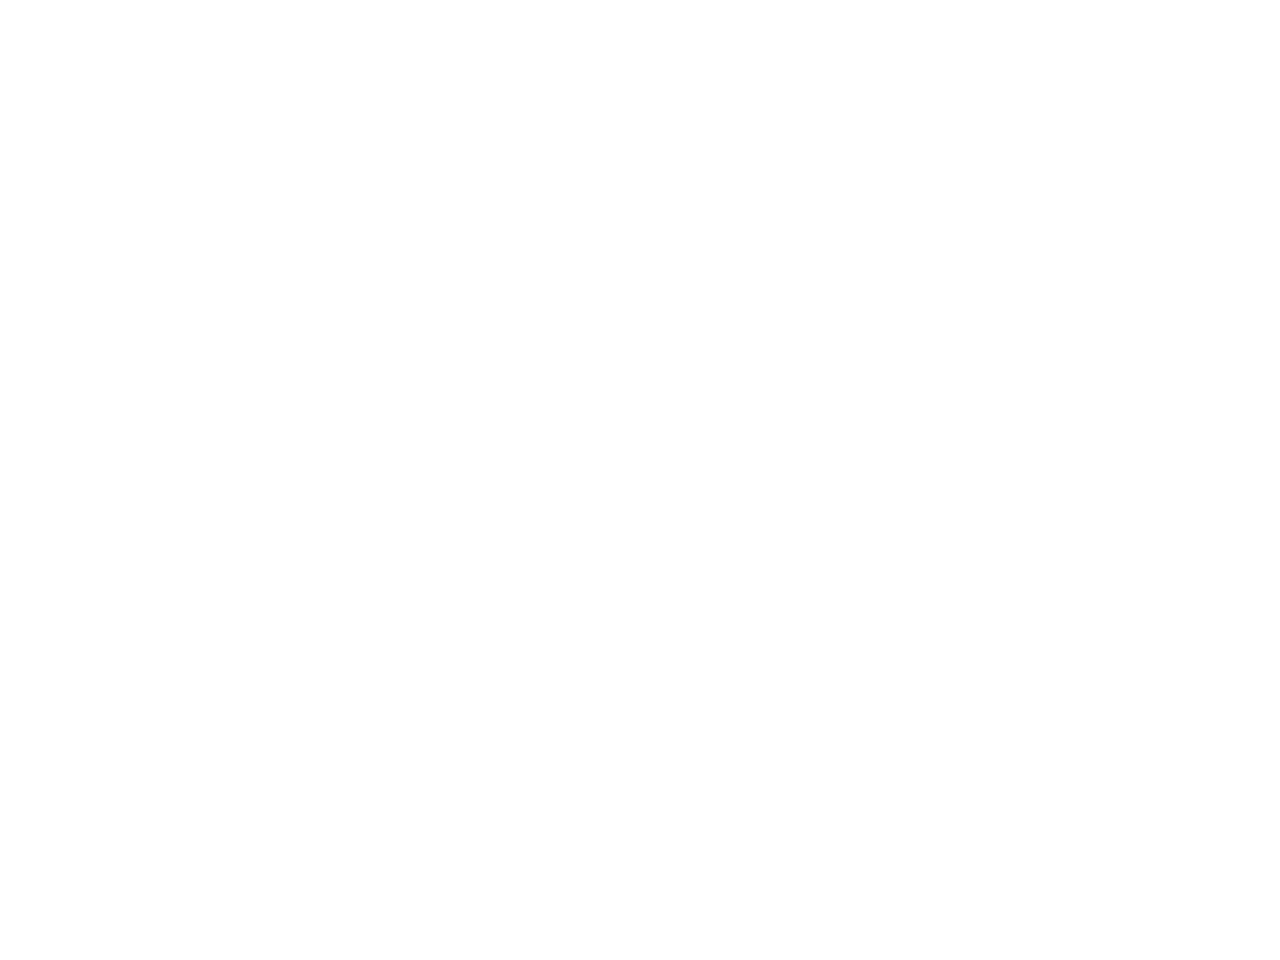

<IPython.core.display.Javascript object>


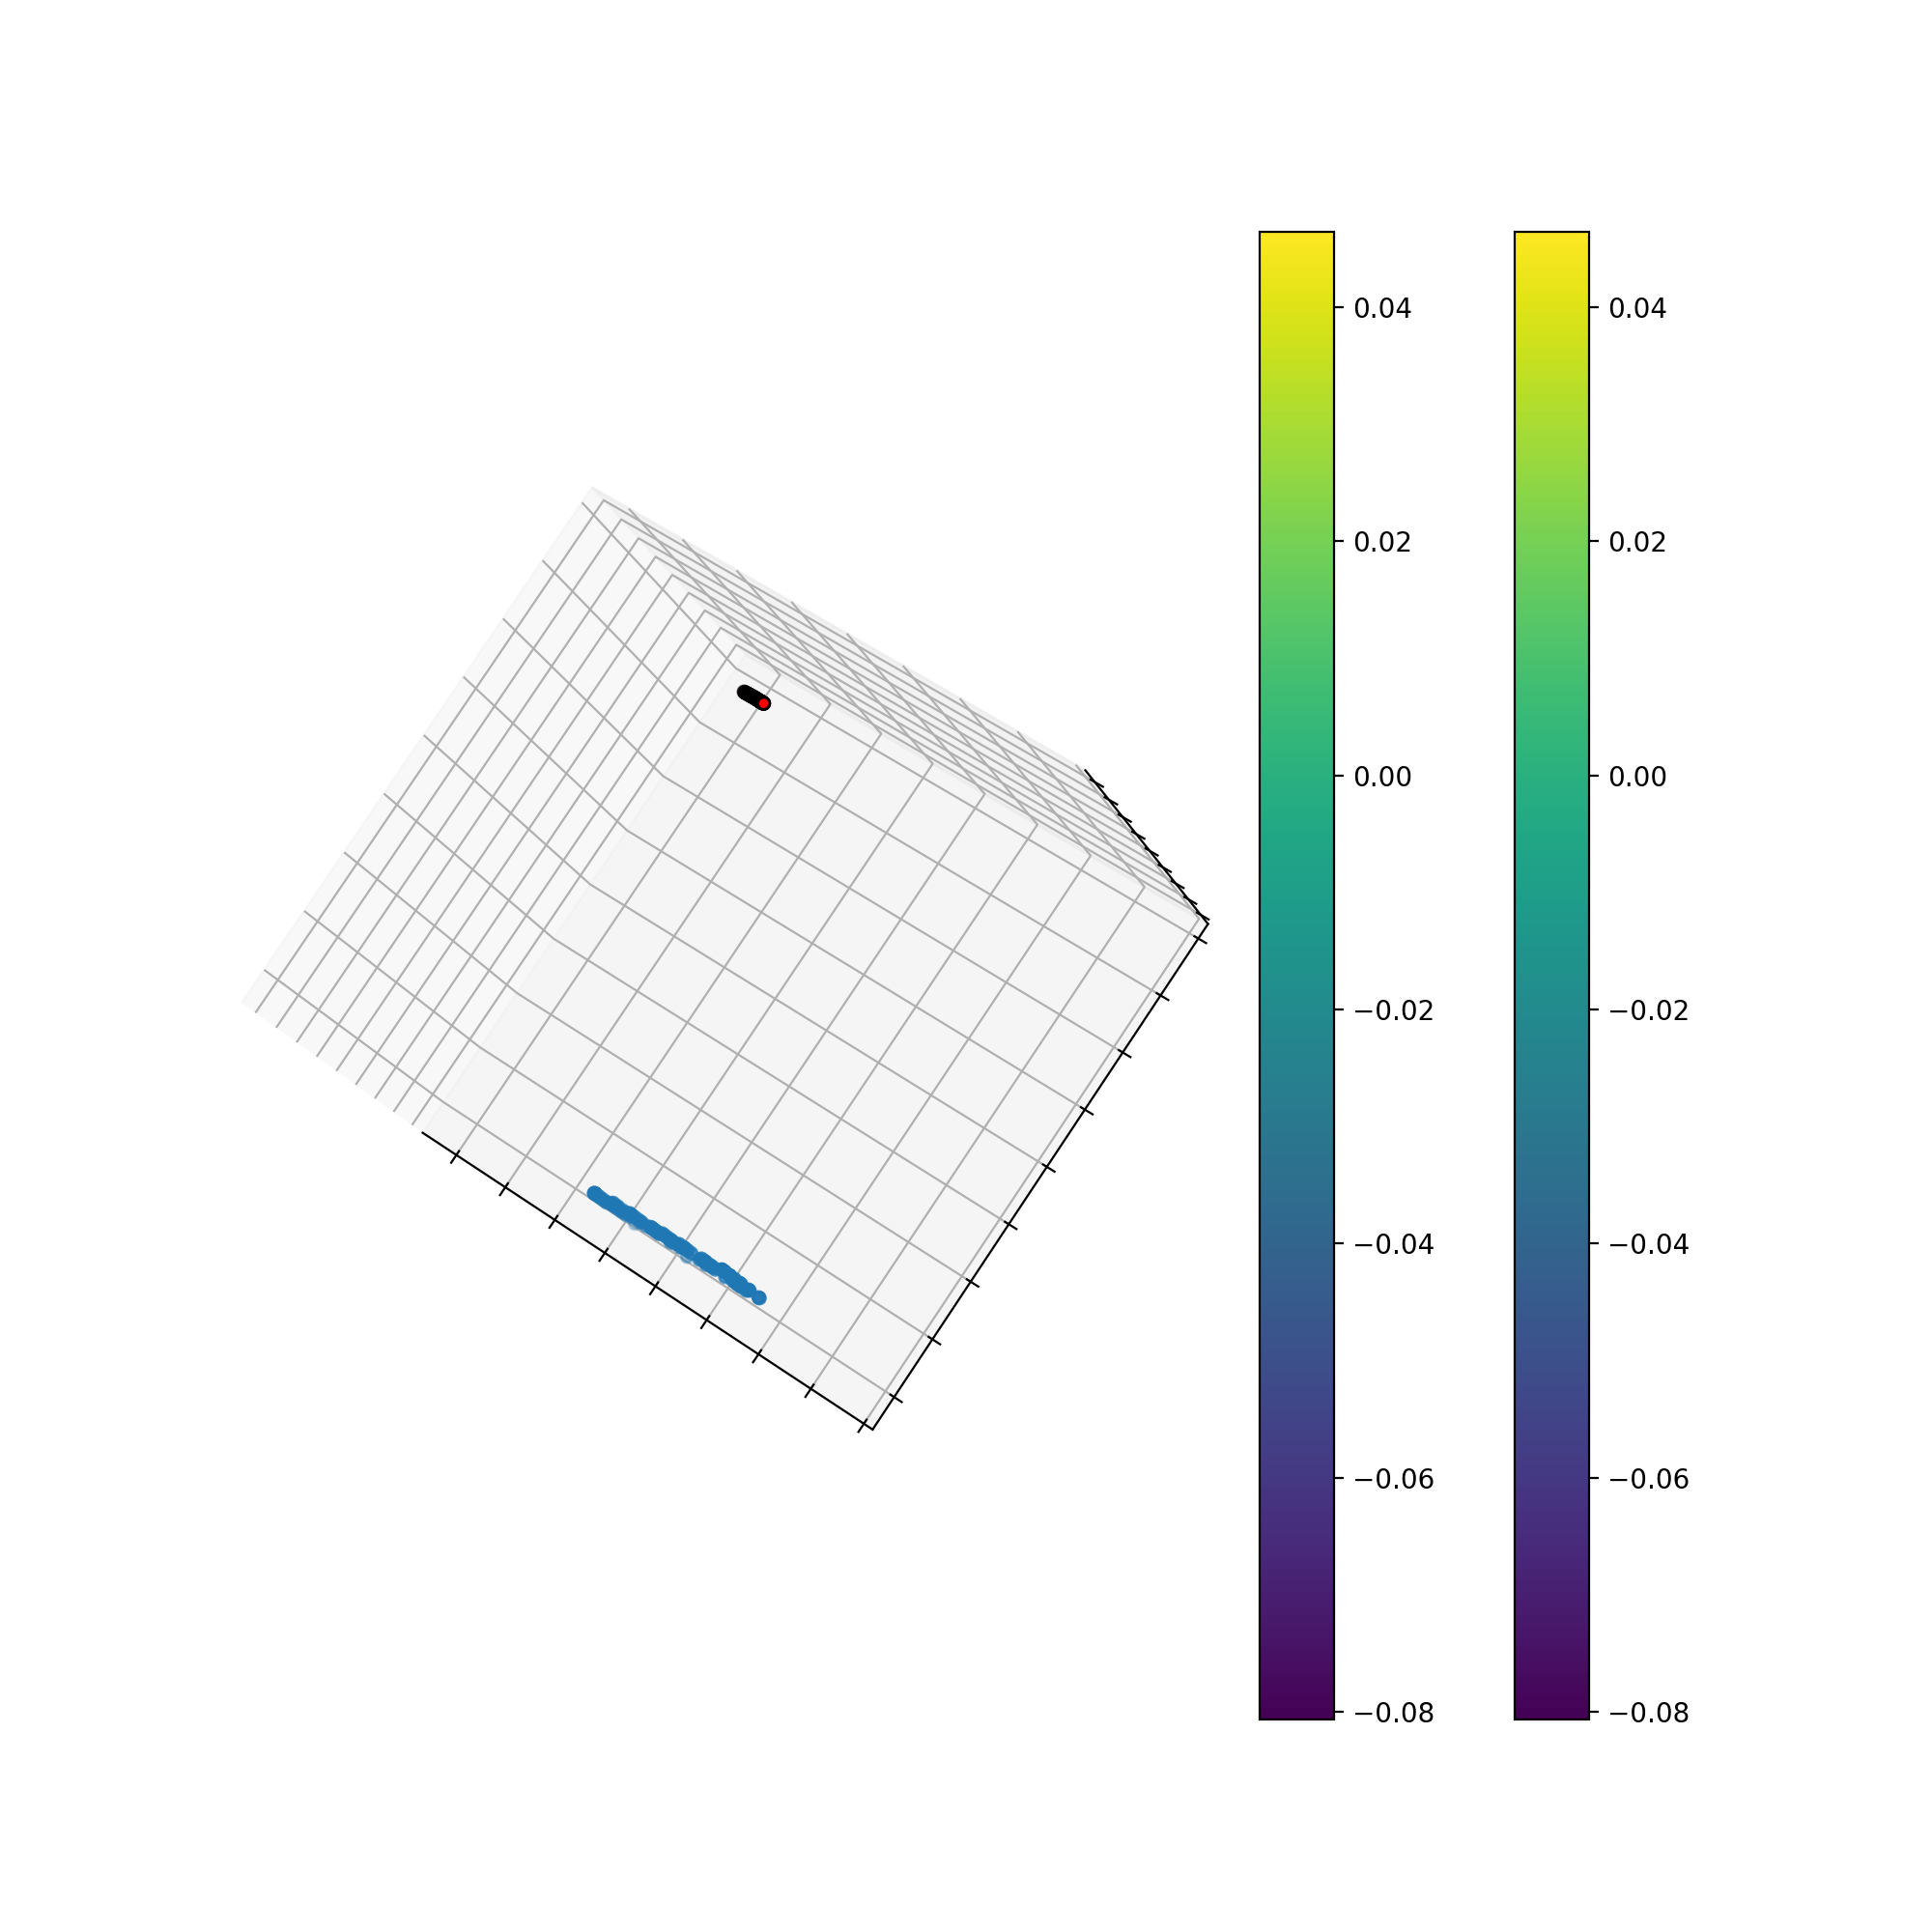

In [ ]:
# %matplotlib nbagg
plt.clf()
# plt.style.use('_mpl-gallery')

# Make data
X = np.arange(sg.shape[1])
Y = np.arange(sg.shape[0])
X, Y = np.meshgrid(X, Y)
Z = sg

# Plot the surface
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={"projection": "3d"})
# ax.plot_surface(X, Y, Z, vmin=Z.min() * 2, cmap="magma")
ax.scatter(peaks_x, peaks_y, peaks_sf)

ax.set(xticklabels=[], yticklabels=[], zticklabels=[])

plt.show()

/tmp/ipykernel_10754/2930591610.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(peaks_y[s_], peaks_x[s_], c="r", cmap="tab10", lw=1, ec="k");


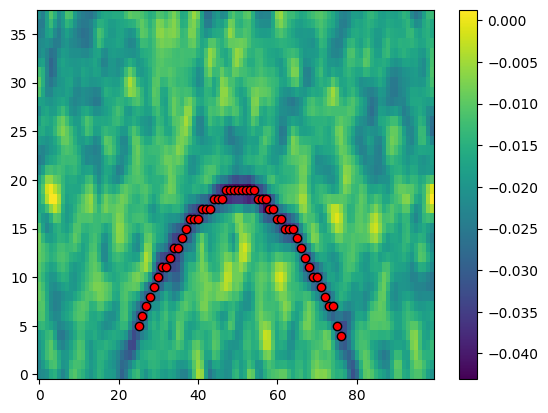

In [ ]:
# hdb = HDBSCAN(copy=True, min_cluster_size=10)
# X = np.stack((peaks_x, peaks_y, peaks_sf)).T
# hdb.fit(X)
# hdb.labels_.shape == (X.shape[0],)
# labels = hdb.labels_

# clusters = np.unique(labels)
# medians = [np.median(peaks_sf[labels == c]) for c in clusters]
# signal = clusters[np.argmax(medians)]

# plt.imshow(zca_sg.T, origin="lower", aspect="auto")
# plt.colorbar()

# s_ = labels == signal
# plt.scatter(peaks_y[s_], peaks_x[s_], c="r", cmap="tab10", lw=1, ec="k");

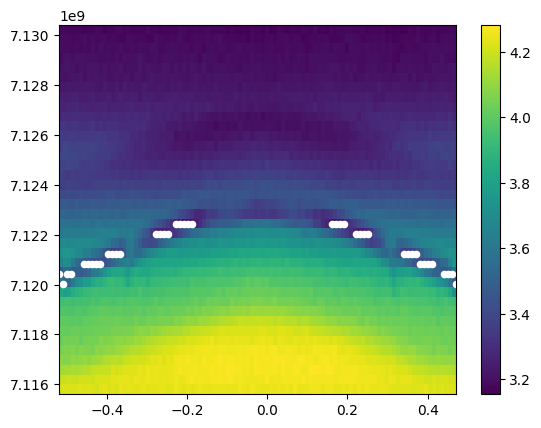

In [87]:
n = 10
mask = np.ones((2 * n + 1, 2 * n + 1))
mask[n, n] = n**2
sc = ndimage.convolve(s, mask)
extract_and_plot(sc, f, b, True, old_flag=True);

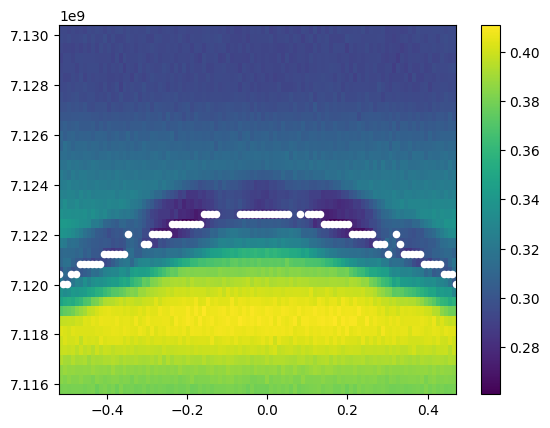

In [88]:
n = 3
mask = np.ones((2 * n + 1, 2 * n + 1))
mask[n, n - 1 : n + 2] = mask[n - 1 : n + 2, n] = -n
mask[n, n] = 2 * n**2
sc = ndimage.convolve(s, mask)
extract_and_plot(sc, f, b, True, old_flag=True);

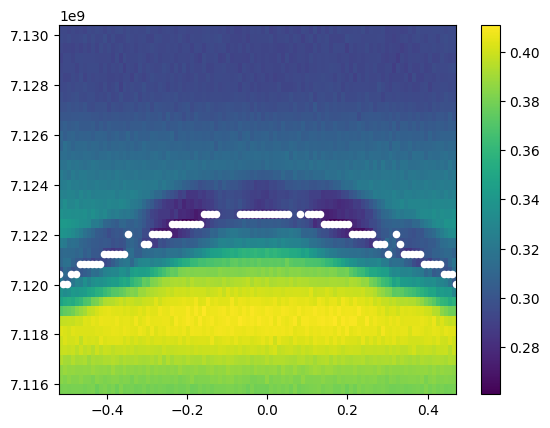

In [89]:
n = 3
mask = np.ones((2 * n + 1, 2 * n + 1))
mask[n, n - 1 : n + 2] = mask[n - 1 : n + 2, n] = -n
mask[n, n] = 2 * n**2
sc = ndimage.convolve(s, mask)
extract_and_plot(sc, f, b, True, old_flag=True);

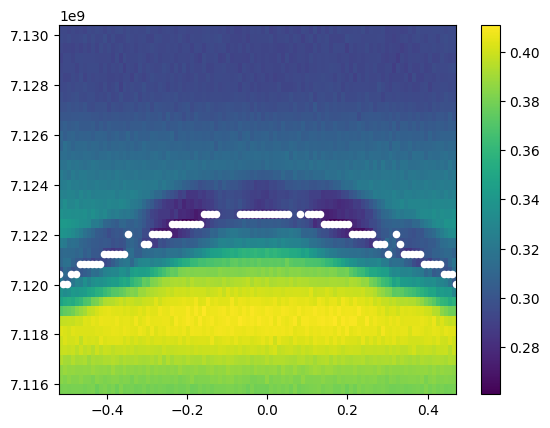

In [90]:
sg = ndimage.gaussian_filter(s, 1)
extract_and_plot(sc, f, b, True, old_flag=True);

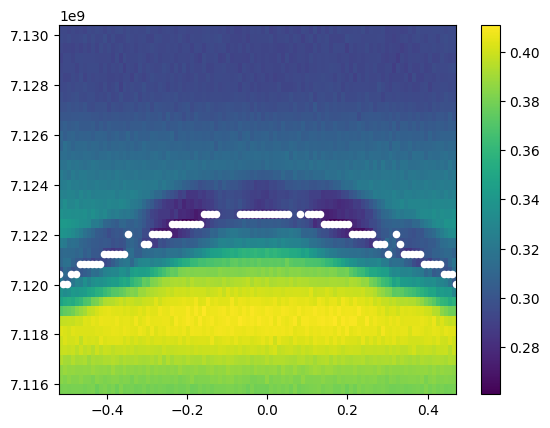

In [91]:
zca = zca_whiten(s)
extract_and_plot(sc, f, b, True, old_flag=True);

In [10]:
def plot_slice(mat, idx, **kwargs):
    sli = mat[idx]
    minim = sli.min()
    line = (sli - minim) / (sli.max() - minim)
    plt.plot(np.arange(line.size), line, **kwargs)
    return find_peaks(line, prominence=0.3)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


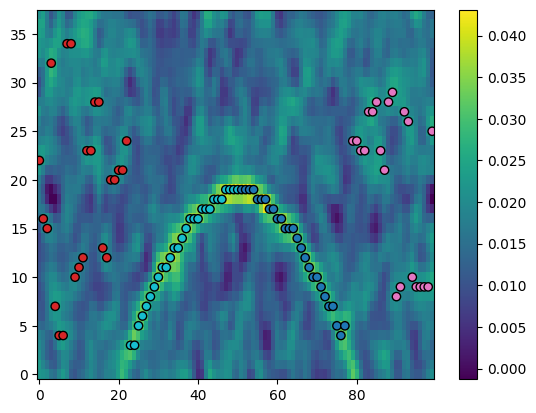

In [ ]:
# from sklearn.cluster import k_means

# _, labels, _ = k_means(np.stack((peaks_x, peaks_y, peaks_sf)).T, 4)

# print(labels)
# plt.imshow(
#     zca_sg.T,
#     # hdb = HDBSCAN(copy=True, min_cluster_size=20)
#     origin="lower",
#     aspect="auto",
# )
# plt.colorbar()

# plt.scatter(peaks_y, peaks_x, c=labels, cmap="tab10", lw=1, ec="k");

In [20]:
def enhance_signal(img, rep):
    for _ in range(rep):
        img_norm = exposure.rescale_intensity(img.astype(float))
        denoised = filters.gaussian(img_norm, sigma=1)
        ridges = filters.meijering(denoised, sigmas=[1, 1], black_ridges=False)
        selem = morphology.disk(5)
        top_hat = morphology.white_tophat(ridges, selem)
        img = top_hat
        # enhanced = exposure.equalize_adapthist(top_hat)
    return img

{'x': {'idx': array([16, 15, 15, 31,  7,  5, 17, 18, 18, 19, 11, 11, 28, 28,  3,  4, 13,
         13, 13, 20, 21, 22, 24, 13,  4,  5,  6,  7,  8,  9, 10, 11, 11, 12,
         13, 13, 14, 15, 15, 16, 16, 17, 17, 17, 18, 18, 18, 18, 18, 19, 19,
         19, 19, 18, 18, 18, 18, 17, 17, 17, 16, 16, 15, 15, 14, 14, 13, 12,
         11, 11, 10,  9,  8,  7,  6,  5,  4, 18, 17, 17, 17, 29, 29, 28, 27,
         11, 12, 20, 19,  8, 30, 28, 26, 25, 24, 17, 17, 18,  9, 10]),
  'val': array([4.99896953e+09, 4.99856953e+09, 4.99856953e+09, 5.00496953e+09,
         4.99536953e+09, 4.99456953e+09, 4.99936953e+09, 4.99976953e+09,
         4.99976953e+09, 5.00016953e+09, 4.99696953e+09, 4.99696953e+09,
         5.00376953e+09, 5.00376953e+09, 4.99376953e+09, 4.99416953e+09,
         4.99776953e+09, 4.99776953e+09, 4.99776953e+09, 5.00056953e+09,
         5.00096953e+09, 5.00136953e+09, 5.00216953e+09, 4.99776953e+09,
         4.99416953e+09, 4.99456953e+09, 4.99496953e+09, 4.99536953e+09,
         4.995

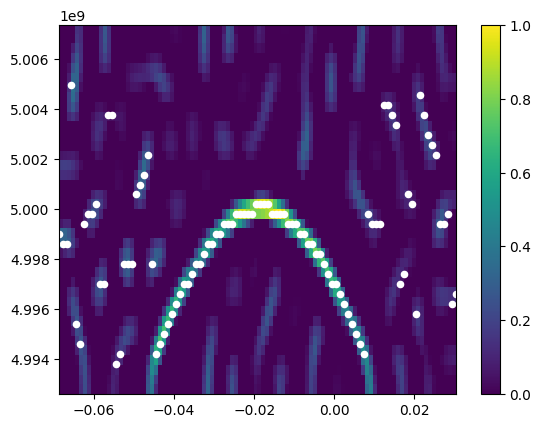

In [21]:
enh_sig = enhance_signal(s, 10)

extract_and_plot(enh_sig, f, b)